# FAIR evaluators

by [Serena Bonaretti](https://sbonaretti.github.io), Maastricht University

---
### Use cases

In this notebook, we consider 4 use-cases of data retrieval in the life sciences. For each case, we
- Execute data retrieval via API 
- Evaluate the FAIRness of the dataset

*Note*: For simplicity, in the following we will use the words `database` and `repository` interchangeably

The 4 use-cases are:


<table>
<colgroup>
<col style="width: 10.0%" />
<col style="width: 22.5%" /> 
<col style="width: 22.5%" /> 
<col style="width: 22.5%" /> 
<col style="width: 22.5%" />
</colgroup>
    
  <tr>
    <th></th>
    <th>Parkinson_AE</th>
    <th>NBIA_GEO</th>  
    <th>TiO2_ENM</th> 
    <th>Caffeine_ChEBI</th>
  </tr>
    
  <tr>
    <th>Research question</th>
    <th>What are the differentially expressed genes between normal subjects and subjects with Parkinson’s diseases in the brain frontal lobe?</th>
    <th>What is the function of mutation of WDR45 protein in the brain?</th>  
    <th>What are the concentrations of titanium dioxide that kill cells?</th> 
    <th>What are the biological roles of caffeine?</th>
  </tr>
  
  <tr>
    <th>Dataset</th>
    <th><a href="https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-1194/?keywords=%22Parkinson%27s%20disease%22%20&organism=Homo%20sapiens&exptype%5B0%5D=&exptype%5B1%5D=%22array%20assay%22&array=&sortby=raw&sortorder=descending&page=1&pagesize=100">E-MTAB-1194</a></th>
    <th><a href="https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE70433">GSE70433</a></th>  
    <th><a href="https://data.enanomapper.net/substance/XLSX-7011cea0-1011-3f8b-9e8a-b3289fed836a/study">NPO_1709 LDH Release Assay (1)</a></th> 
    <th><a href="https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:27732">CHEBI:27732 - caffeine</a></th>
  </tr>
  
  <tr>
    <th>Database</th>
    <th><a href="https://www.ebi.ac.uk/arrayexpress/">ArrayExpress</a></th>
    <th><a href="https://www.ncbi.nlm.nih.gov/geo/">Gene Expression Omnibus</a></th>  
    <th><a href="https://data.enanomapper.net">data.eNanoMapper</a></th> 
    <th><a href="https://www.ebi.ac.uk/chebi/">ChEBI</a></th> 
  </tr>

</table>




Information about databases:
- **ArrayExpress**:
  - API: 
    - Documentation at https://www.ebi.ac.uk/arrayexpress/help/programmatic_access.html  
    - The API to query the database is a rest API: https://www.ebi.ac.uk/arrayexpress/xml/v3/experiments
    - The API to get data is an FTP API: ftp://ftp.ebi.ac.uk/pub/databases/arrayexpress/data/  
  - Data structure:
    - Metadata are separated in two different layers, accessible via:
      - Generic metadata: accessible via rest API  
      - Specific metadata: accessible via FTP API  
      
      
- **Gene Expression Omnibus**: 
  - API: 
    - Documentation at https://www.ncbi.nlm.nih.gov/geo/info/geo_paccess.html
    - 5 possible queries are possible (https://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4):  
      - eSearch: results of a search   
        (base URL: https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi)  
      - eSummary: document summary   
        (base URL: https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi)   
      - eFetch: formatted data records  
        (base URL: https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi)
      - eLink: links to same or different databases   
        (base URL: https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi)
      - eInfo: statistics for a single database, including lists of indexing fields and available link names  
        (base URL: https://eutils.ncbi.nlm.nih.gov/entrez/eutils/einfo.fcgi)
        
        
- **ChEBI**
  - API: 
    - Documentation at https://www.ebi.ac.uk/chebi/webServices.do
    - It uses the SOAP protocol -> python libray to use is `zeep`
    - It provides 8 possible operations for query:  
      - getAllOntologyChildrenInPath  
      - getCompleteEntity (input: `chebiId` of element)
      - getCompleteEntityByList  
      - getLiteEntity (input: `chebiAsciiName` of element) 
      - getOntologyChildren  
      - getOntologyParents  
      - getStructureSearch  
      - getUpdatedPolymer  
 


---

### Calculating FAIR metrics

[Imports](#imports)  
[Variables](#variables)  
[Functions](#functions)  

[Retriving datasets:](#retrieval)  
- [Case 1: Parkinson_AE](#Parkinson_AE)  
- [Case 2: NBIA_GEO](#NBIA_GEO)  
- [Case 3: TiO2_ENM](#TiO2_ENM)  
- [Case 4: Caffeine_ChEBI](#Caffeine_ChEBI)

[FAIR assessment:](#metrics) 
- [F1. (Meta)data are assigned a globally unique and persistent identifier](#F1) 
- [F2. Data are described with rich metadata](#F2) 
- [F3. Metadata clearly and explicitly include the identifier of the data it describes](#F3)  
- [F4. (Meta)data are registered or indexed in a searchable resource](#F4) 
- [A1. (Meta)data are retrievable by their identifier using a standardized communications protocol](#A1)    
- [A2. Metadata are accessible, even when the data are no longer available](#A2)  
- [I1. (Meta)data use a formal, accessible, shared, and broadly applicable language for knowledge representation](#I1) 
- [I2. Metadata use vocabularies that follow FAIR principles](#I2)  
- [I3. (Meta)data include qualified references to other (meta)data](#I3)   
- [R1.1. (Meta)data are released with a clear and accessible data usage license](#R11)  
- [R1.2. (Meta)data are associated with detailed provenance](#R12)  
- [R1.3. (Meta)data meet domain-relevant community standards](#R13)

[FAIR assessment visualization](#visualization)

---

<a name="imports"></a>
#### Imports:

In [1]:
# import python packages
import bs4
import os
import pandas as pd
import requests
import xml.etree.ElementTree as ET
from io import StringIO

In [2]:
# Import R for visualization using ggplot2: 
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Resources' # put here your own R directory
%load_ext rpy2.ipython

<a name="variables"></a>
#### Variables:

In [3]:
# Google API   
google_search    = "https://www.google.com/search?q="
# re3Data API
re3data_repos    = "https://www.re3data.org/api/v1/repositories"
re3data_repo     = "https://www.re3data.org/api/v1/repository"
re3data_schema   = '{http://www.re3data.org/schema/2-2}' # in the metadata xml

In [4]:
# repository variables
repository_name  = []
repository_api   = []
dataset_download = []

# ArrayExpress
repository_name.append("ArrayExpress")
repository_api.append("https://www.ebi.ac.uk/arrayexpress/xml/v3/experiments")
dataset_download.append("https://www.ebi.ac.uk/arrayexpress/xml/v3/files/")

# GEO
repository_name.append("Gene Expression Omnibus")
repository_api.append("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?")
metadata_api       = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?"
repository_acronym = "gds" # gene dataset

# eNanoMapper
repository_name.append("data.enanomapper")

# ChEBI
repository_name.append("ChEBI")

In [5]:
# case names
case_name        = []
case_name.append("Parkinson_AE")
case_name.append("NBIA_GEO")
case_name.append("TiO2_ENM")
case_name.append("Caffeine_ChEBI")

In [6]:
# search keywords
keywords = []

# ArrayExpress
kw = []
kw.append("Parkinson's disease")
kw.append("transcription profiling by array")
kw.append("Homo sapiens")
kw.append("frontal lobe")
kw.append("male")
kw.append("female")
kw.append("normal")
kw.append("true")
keywords.append(kw)

# GEO
kw = []
kw.append("nbia")
kw.append("homo sapiens")
kw.append("expression profiling by array")
keywords.append(kw)

# eNanoMapper
kw = []
#keywords.append(kw)

# ChEBI
kw = []
#keywords.append(kw)

In [7]:
# output variables used for FAIR assessment

request_status = []
metadata       = []
dataset_title  = []

F1  = []
F2  = []
F3  = []
F4  = []
A1  = []
A2  = []
I1  = []
I2  = []
I3  = []
R1  = []
R11 = []
R12 = []
R13 = []

<a name="functions"></a>
#### Functions:

In [8]:
def find_repo_in_re3_data (repository_name):
    """
    It retrieves metadata about the input repository in re3data.org
    """
    
    
    # contact the registry
    re3data_r = requests.get(re3data_repos)
    # put output string in a structured xml tree
    re3data_root = ET.fromstring(re3data_r.text)

    # look for the wanted repository
    flag = 0
    for i in range (0, len(re3data_root)):
        if re3data_root[i][1].text == repository_name: # first index is a <repository> group, 
                                                       # second index is for the tags inside (<id>, <name>, <link>)
            flag = 1
            repository_index = i

    if flag == 1:   
        
        re3data_metadata_address = str(re3data_root[repository_index][2].attrib["href"])
        
        #print ("Index in list: " + str(repository_index))
        #print ("Tag          : " + str(re3data_root[repository_index][1].tag))
        #print ("Text         : " + str(re3data_root[repository_index][1].text))
        #print ("Tag          : " + str(re3data_root[repository_index][2].tag))
        #print ("Attribute    : " + str(re3data_root[repository_index][2].attrib)) # attributes do not have a closing tag

    else: 
        print ("Repository not found")
        
    return re3data_metadata_address

In [9]:
def look_for_tag_re3data (root, schema, characteristic):
    
    """ 
    It extract text corresponding to provided tag in re3data
    """
    
    # look for content
    text = []

    for i in range (0, len(root[0])):

        # tag
        tag  = root[0][i].tag
        tag  = tag.replace(schema, "")

        if tag == characteristic:            
            if len(root[0][i]) == 0:
                text.append(root[0][i].text)
            else:
                for a in range (0, len(root[0][i])):
                    tag  = root[0][i][a].tag
                    tag  = tag.replace(schema, "") # to improve redeability
                    text.append(root[0][i][a].text)

    return text

In [10]:
def pretty_print_xml (root): 
    """
    It prints xml with identations
    """
    
    count = 0
    for i in range (0, len(root)):

        if len(root[i]) == 0:
            print ("<"  + str(root[i].tag) + ">")
            print ("   " + str(root[i].text))
            count = count + 1
        else: 
            for j in range(0, len(root[i])):
                if len(root[i][j]) == 0:
                    print ("<"  + str(root[i][j].tag) + ">")
                    print ("   " + str(root[i][j].text))
                    print ("<"  + str(root[i][j].tag + ">"))
                    count = count + 1
                else: 
                    for k in range (0, len(root[i][j])):
                        print ("  <"  + str(root[i][j][k].tag + ">"))
                        print ("      " + str(root[i][j][k].text))
                        count = count + 1
    return count

In [11]:
def find_id_in_metadata(id_tag, metadata, repository_name): 
    """
    Given id_tag and the metadata, finds the id in the metadata, an returns yes or no
    repository_name is for print
    metadata is in xml
    """
    
    for i in range (0, len(metadata)):
        if metadata[i].tag == id_tag:
            identifier = metadata[i].text
            print (repository_name + ": dataset identifier = " + str(identifier))
    # assign value to F3
    if identifier.isdigit():
        output = 1
    else:
        output = 0
    
    return output
    
   

---

<a name="retrieval"></a>
### Retriving datasets 

<a name="Parkinson_AE"></a>
#### Case 1: Parkinson_AE

In [12]:
case_id = 0

In [13]:
r_repo = requests.get(repository_api[case_id],
                  params={"keywords"      :  keywords[case_id][0], # "Parkinson's disease"
                          "experimenttype":  keywords[case_id][1], # "transcription profiling by array"
                          "organism"      :  keywords[case_id][2], # "Homo sapiens" 
                          "sa"            : [keywords[case_id][0], keywords[case_id][3], keywords[case_id][4], keywords[case_id][5]],  # "Parkinson's disease", "frontal lobe", "male", "female"
                          "diseasestate"  : [keywords[case_id][0], keywords[case_id][6]], # "Parkinson's disease",  "normal"
                          "raw"           :  keywords[case_id][7]})

request_status.append(r_repo.status_code)

root = ET.fromstring(r_repo.text)
print("number of datasets found: " + str (len(root)))

number of datasets found: 2


Because the query via API reports 2 results, we have to investigate a second layer of metadata that is not provided in the API but is part of the downloadable package.  
We use this metadata only to to select the dataset to use, not to assess FAIRness

In [14]:
# look for experiment_id 
experiment_id = []

for accession in root.iter('accession'):
    if len(accession.text) == 11:
        experiment_id.append(accession.text)
print (experiment_id)

['E-MTAB-1194', 'E-GEOD-7307']


In [15]:
# get metadata of dataset 1
d1_url = dataset_download[0] + experiment_id[0] + "/"
d1_r = requests.get(d1_url)
# pass output to ET
d1_root = ET.fromstring(d1_r.text)

# look for urls of file names to download
for url in d1_root.iter('url'):
    if "sdrf.txt" in str(url.text):
        d1_sdrf_name = url.text
    
# get file
df1_r = requests.get(d1_sdrf_name)

# convert string tabular text to pandas dataframe
full_string = StringIO(df1_r.text)
df1 = pd.read_csv(full_string, sep="\t")
# df1

# check how many columns with "Parkinson's desease" correspond to "frontal lobe"
b = df1[ ( df1["Characteristics[DiseaseState]"] == "Parkinson's disease" ) & (df1["Characteristics[OrganismPart]"] == "frontal lobe")]
df1_n_of_corresponding_rows = b.shape[0]
#b

In [16]:
# get metadata of the dataset 2
d2_url = dataset_download[0] + experiment_id[1] + "/"
d2_r = requests.get(d2_url)
# pass output to ET
d2_root = ET.fromstring(d2_r.text)

# look for urls of file names to download
for url in d2_root.iter('url'):
    if "sdrf.txt" in str(url.text):
        d2_sdrf_name = url.text
    
# get file
df2_r = requests.get(d2_sdrf_name)

# convert string tabular text to pandas dataframe
full_string = StringIO(df2_r.text)
df2 = pd.read_csv(full_string, sep="\t")

# show all columns
n_of_columns = df2.shape[1]
pd.set_option("display.max_columns",n_of_columns)
pd.set_option("display.max_rows",10)
#df2

# check if columns with "Parkinson's desease" correspond to "frontal lobe"
b = df2[ ( df2["Characteristics [DiseaseState]"] == "Parkinson's disease" ) & (df2["Characteristics [OrganismPart]"] == "frontal lobe")]
df2_n_of_corresponding_rows = b.shape[0]
# b

In [17]:
# select the dataset 
if df1_n_of_corresponding_rows > df2_n_of_corresponding_rows:
    metadata.append(root[0])
    print ("Using dataset: " + str(experiment_id[0]))
else: 
    metadata.append(root[1])
    print ("Using dataset: " + str(experiment_id[0]))

Using dataset: E-MTAB-1194


In [18]:
# print metadata
# pretty_print_xml (metadata[case_id])

<a name="NBIA_GEO"></a>
#### Case 2: NBIA_GEO

In [19]:
case_id = 1

In [20]:
# query repository
query_string = keywords[case_id][0] +  " AND " + keywords[case_id][1] + " AND " + keywords[case_id][2]
r_repo = requests.get(repository_api[case_id],
                  params={"db"   : repository_acronym,
                          "term" : query_string})
request_status.append(r_repo.status_code)

# convert answer from string to xml_tree
root = ET.fromstring(r_repo.text)

#pretty_print_xml (root)

In [21]:
# get identifier
for field in root.iter('Id'):
    id = field.text

# get metadata
r_meta = requests.get(metadata_api,
                  params={"db" : repository_acronym,
                          "id" : id})
root_meta = ET.fromstring(r_meta.text)
metadata.append(root_meta[0])

In [22]:
# print metadata
# pretty_print_xml (metadata[case_id])

<a name="TiO2_ENM"></a>
#### Case 3: TiO2_ENM

In [23]:
case_id = 2

<a name="Caffeine_ChEBI"></a>
#### Case 4: Caffeine_ChEBI

In [24]:
case_id = 3



---

<a name="metrics"></a>
### FAIR assessment

---

<a name="F1"></a>
#### F1. (Meta)data are assigned a globally unique and persistent identifier
We used www.re3data.org to check whether the repository provides a globally unique and persistent identifier.  
Because it is not possible to retrieve this information via API, we manually checked the "doi" icon at the top-right of each repository page. 
We manually assigned: 
- `1` when the hovered icon stated: *The research data repository uses DOI to make its provided data persistent, unique and citable* 
- `0` when the hovered icon stated: *The research data repository does not use a persistent identifier system*  

In [25]:
# Parkinson_AE
F1.append(0) # information retrieved at: https://www.re3data.org/repository/r3d100010222

# NBIA_GEO
F1.append(0) # information retrieved at: https://www.re3data.org/repository/r3d100010283

# TiO2_ENM
F1.append(0) # information retrieved at: https://www.re3data.org/repository/r3d100013052

# Caffeine_ChEBI
F1.append(0) # information retrieved at: https://www.re3data.org/repository/r3d100012626

# Print out F1 values
print ("--> F1 are: " + str(F1) )

--> F1 are: [0, 0, 0, 0]


---

<a name="F2"></a>
#### F2. Data are described with rich metadata 

Metadata contain the keywords used in the query

In [26]:
# Parkinson_AE

case_id = 0
print (repository_name[case_id])

# counter 
n_found_keywords = 0

# look for publication authors, title, and email of corresponding author 
for i in range (0, len(metadata[case_id])):
    
    # disease - Parkinson's disease
    if len(metadata[case_id][i]) > 2:
        if str(metadata[case_id][i].tag) == "samplecharacteristic" and str(metadata[case_id][i][2].text).find(keywords[case_id][0]) != -1: # "Parkinson's disease":
            print ("Keyword *" + str(metadata[case_id][i][2].text) + "* found")
            n_found_keywords = n_found_keywords + 1
    
    # experiment type
    if str(metadata[case_id][i].tag) == "experimenttype"           and str(metadata[case_id][i].text).find(keywords[case_id][1])    != -1: # "transcription profiling by array"
        print ("Keyword *" + str(metadata[case_id][i].text) + "* found")
        n_found_keywords = n_found_keywords + 1
        
    # homo sapiens
    if str(metadata[case_id][i].tag) == "samplecharacteristic"     and str(metadata[case_id][i][1].text).find(keywords[case_id][2]) != -1: # "Homo sapiens":
        print ("Keyword *" + str(metadata[case_id][i][1].text) + "* found")
        n_found_keywords = n_found_keywords + 1

    # frontal lobe
    if str(metadata[case_id][i].tag) == "samplecharacteristic"     and str(metadata[case_id][i][1].text).find(keywords[case_id][3]) != -1: # "frontal lobe":
        print ("Keyword *" + str(metadata[case_id][i][1].text) + "* found")
        n_found_keywords = n_found_keywords + 1
        
    # sex - male
    if len(metadata[case_id][i]) > 2:
        if str(metadata[case_id][i].tag) == "samplecharacteristic" and str(metadata[case_id][i][2].text).find(keywords[case_id][4]) != -1: # "male":
            print ("Keyword *" + str(metadata[case_id][i][2].text) + "* found")
            n_found_keywords = n_found_keywords + 1
            
    # sex - female
    if str(metadata[case_id][i].tag) == "samplecharacteristic"     and str(metadata[case_id][i][1].text).find(keywords[case_id][5]) != -1: # "female":
        print ("Keyword *" + str(metadata[case_id][i][1].text) + "* found")
        n_found_keywords = n_found_keywords + 1
    
    # disease - normal
    if str(metadata[case_id][i].tag) == "samplecharacteristic"     and str(metadata[case_id][i][1].text).find(keywords[case_id][6]) != -1: # "normal":
        print ("Keyword *" + str(metadata[case_id][i][1].text))
        n_found_keywords = n_found_keywords + 1
    
    # raw data 
    if str(metadata[case_id][i].tag) == "bioassaydatagroup": #rawData
        print ("Keyword: " + str(metadata[case_id][i][1].text))
        n_found_keywords = n_found_keywords + 1

# assign F2
if n_found_keywords == 0:           # none of the search keywords are in the metafile data
    F2.append(0)
else:
    F2.append(n_found_keywords/len(keywords[case_id]))
    
print ("Total number of keywords in search: " + str(len(keywords[case_id])))
print ("Total number of keywords found in metadata: " + str(n_found_keywords))

ArrayExpress
Keyword *transcription profiling by array* found
Keyword *Parkinson's disease* found
Keyword *normal
Keyword *Homo sapiens* found
Keyword *frontal lobe* found
Keyword *male* found
Keyword *female* found
Keyword: rawData
Total number of keywords in search: 8
Total number of keywords found in metadata: 8


In [27]:
# NBIA_GEO
 
case_id = 1
print (repository_name[case_id])

# counter 
n_found_keywords = 0

# look for publication authors, title, and email of corresponding author 
for i in range (0, len(metadata[case_id])):
    
    # nbia
    if str(metadata[case_id][i].text).lower().find(keywords[case_id][0]) != -1:
        print ("Keyword *" + str(metadata[case_id][i].text) + "* found")
        n_found_keywords = n_found_keywords + 1
    
    # homo sapiens
    if str(metadata[case_id][i].text).lower().find(keywords[case_id][1]) != -1:
        print ("Keyword *" + str(metadata[case_id][i].text) + "* found")
        n_found_keywords = n_found_keywords + 1

    
    # experiment type
    if str(metadata[case_id][i].text).lower().find(keywords[case_id][2]) != -1:
        print ("Keyword *" + str(metadata[case_id][i].text) + "* found")
        n_found_keywords = n_found_keywords + 1

# assign F2
if n_found_keywords == 0:           # none of the search keywords are in the metafile data
    F2.append(0)
else:
    F2.append(n_found_keywords/len(keywords[case_id]))
    
print ("Total number of keywords in search: " + str(len(keywords[case_id])))
print ("Total number of keywords found in metadata: " + str(n_found_keywords))


Gene Expression Omnibus
Keyword *Mus musculus; Homo sapiens* found
Keyword *Expression profiling by array* found
Total number of keywords in search: 3
Total number of keywords found in metadata: 2


In [28]:
# TiO2_ENM
case_id = 2
print (repository_name[case_id])

# counter 
n_found_keywords = 0

# to be done

F2.append(None)

data.enanomapper


In [29]:
# Caffeine_ChEBI
case_id = 3
print (repository_name[case_id])

# counter 
n_found_keywords = 0

# to be done

F2.append(None)

ChEBI


In [30]:
print ("--> F2: " + str(F2))

--> F2: [1.0, 0.6666666666666666, None, None]


---

<a name="F3"></a>
#### F3. Metadata clearly and explicitly include the identifier of the data it describes  

In [31]:
def find_id_in_metadata(id_tag, metadata, repository_name): 
    """
    Given id_tag and the metadata, finds the id in the metadata, an returns yes or no
    repository_name is for print
    metadata is in xml
    """
    
    for i in range (0, len(metadata)):
        if metadata[i].tag == id_tag:
            identifier = metadata[i].text
            print (repository_name + ": dataset identifier = " + str(identifier))
    # assign value to F3
    if identifier.isdigit():
        output = 1
    else:
        output = 0
    
    return output
    
   

In [32]:
# Parkinson_AE
case_id = 0
found_id = find_id_in_metadata("id", metadata[case_id], repository_name[case_id])
F3.append(found_id)

# NBIA_GEO
case_id = 1
found_id = find_id_in_metadata("Id", metadata[case_id], repository_name[case_id])
F3.append(found_id)

# TiO2_ENM
case_id = 2
# to be done
F3.append(None)

# Caffeine_ChEBI
case_id = 3
# to be done
F3.append(None)

print ("--> F3: " + str(F3) )

ArrayExpress: dataset identifier = 219251
Gene Expression Omnibus: dataset identifier = 200070433
--> F3: [1, 1, None, None]


---

<a name="F4"></a>
#### F4. (Meta)data are registered or indexed in a searchable resource

Search for the dataset title in www.google.com

In [33]:
# Parkinson_AE
case_id = 0

# get dataset title
for i in range(0, len(metadata[case_id])):
    if str(metadata[case_id][i].tag) == "name":
        dataset_title.append(metadata[case_id][i].text)
# find dataset in google
        
# NBIA_GEO
case_id = 1

# get dataset title
dataset_title.append(str(metadata[case_id][3].text))
# find dataset in google

print ("Dataset titles") 
print (dataset_title)

# to be implemented
F4.append(None)
F4.append(None)
F4.append(None)
F4.append(None)

print ("--> F4: " + str(F4) )


Dataset titles
['Transcription profiling by array of human frontal cortex (area 8) from Parkinson disease cases and controls', 'Gene expression in human or mouse brain with iron loading']
--> F4: [None, None, None, None]


In [34]:
# # query Google API for repository_url

# string_to_find = repository_name[case_id] # dataset_title[case_id]

# r = requests.get(google_search + string_to_find)
# soup = bs4.BeautifulSoup(r.text, "html.parser")
# link_elements = soup.select('.r a')
# #soup = bs4.BeautifulSoup(r.text, "lxml")
# for item in soup.select(".r a"): # .r is a class in html; a is a link
#     print (item.text)


# # find repository_url in the search output
# counts = 0
# for i in range(len(link_elements)):
#     if (link_elements[i].find (string_to_find) != -1):     
#         counts = counts + 1
        

# # assign F4: It is 0 if repository_url is not present  in the search output, it is 1 otherwise
# if counts != 0:
#     print ("*" + string_to_find + "* found in " + str(counts) + " urls out of " + str(len(link_elements)) )
#     F4 = 1
# else: 
#     print ("*" + string_to_find + "* not found in the first " + str(len(link_elements)) + " urls")
#     F4 = 0
    
# print ("F4: " + str(F4))

---

<a name="A1"></a>
#### A1. Metadata are retrievable by their identifier using a standardized communications protocol   
**A1.1 The protocol is open, free, and universally implementable**   
**A1.2 The protocol allows for an authentication and authorization procedure, where necessary** 

In this implementation we retrieve information only via HTTP

In [35]:
# for all use cases
for i in range(0, len(request_status)):
    if request_status == 200:
        A1.append(1) 
    else:
        A1.append(0) 
print ("--> A1: " + str(A1))  

# for enanomapper and chebi
A1.append(None)
A1.append(None)
print ("--> A1: " + str(A1)) 

--> A1: [0, 0]
--> A1: [0, 0, None, None]


<a name="A2"></a>
#### A2. Metadata are accessible, even when the data are no longer available  
*Interpretation:* If metadata do not have a unique identifier, there is no guarantee that they are accessible in the future 

-> Look for policy

In [36]:
print ("to be double-checked")
A2.append(None)
A2.append(None)
A2.append(None)
A2.append(None)

print ("--> A2: " + str(A2) )


to be double-checked
--> A2: [None, None, None, None]


---

<a name="I1"></a>
#### I1. Metadata use a formal, accessible, shared, and broadly applicable language for knowledge representation 

ArrayExpress provides metadata in XLM format using its specific schema:   
https://www.ebi.ac.uk/arrayexpress/help/programmatic_access.html#Format_XML_results  
(https://www.ebi.ac.uk/arrayexpress/help/programmatic_access.html)  

In [37]:
print ("to be double-checked")
I1.append(0.5)   # manual assignment
I1.append(None)
I1.append(None)
I1.append(None)

print ("--> I1: " + str(I1) )    

to be double-checked
--> I1: [0.5, None, None, None]


---

<a name="I2"></a>
#### I2. Metadata use vocabularies that follow FAIR principles
We did not assess this principle

In [38]:
# Parkinson_AE
I2.append(None) 
# NBIA_GEO
I2.append(None) 
# TiO2_ENM
I2.append(None) 
# Caffeine_ChEBI
I2.append(None) 

print ("--> I2: " + str(I2))

--> I2: [None, None, None, None]


---

<a name="I3"></a>
#### I3. (Meta)data include qualified references to other (meta)data  
Manually checked if there are references in metadata

In [39]:
print ("to be double-checked")
# Parkinson_AE
I3.append(None) 
# NBIA_GEO
I3.append(None) 
# TiO2_ENM
I3.append(None) 
# Caffeine_ChEBI
I3.append(None) 
print ("--> I3: " + str(I3))

to be double-checked
--> I3: [None, None, None, None]


---

<a name="R1"></a>
#### R1 (meta)data are richly described with a plurality of accurate and relevant attributes 
Metadata contained other information (e.g. subject age), but this information was not relevant for this research question
- To be changed: I will consider extra info in general

In [40]:
print ("to be double-checked")
# Parkinson_AE
R1.append(None) 
# NBIA_GEO
R1.append(None) 
# TiO2_ENM
R1.append(None) 
# Caffeine_ChEBI
R1.append(None) 
print ("--> R1: " + str(R1))

to be double-checked
--> R1: [None, None, None, None]


---

<a name="R11"></a>
#### R1.1. Metadata are released with a clear and accessible data usage license  

Assumption: License stated in www.re3data.org

In [41]:
for i in range (0, len(repository_name)): 
    
    # extract repository metadata
    re3data_metadata_address = find_repo_in_re3_data (repository_name[i])

    # extract repository number 
    repository_number = re3data_metadata_address[re3data_metadata_address.rfind('/') : len(re3data_metadata_address)]

    # metadata_url
    metadata_url      = re3data_repo + str(repository_number)

    # access the repository metadata 
    re3data_repo_r = requests.get(metadata_url)

    # put the r_repo string in a structured xml tree
    re3data_repo_root = ET.fromstring(re3data_repo_r.text)
    
    # get repository license
    output = look_for_tag_re3data (re3data_repo_root, re3data_schema, 'dataLicense')
    
    print (repository_name[i])
    print (output)
    
    if output[1] != []:
        R11.append(1) 
    else: 
        R11.append(0)

print ("--> R11: " + str(R11)) 


ArrayExpress
['other', 'https://www.ebi.ac.uk/arrayexpress/help/data_availability.html']
Gene Expression Omnibus
['Copyrights', 'http://www.ncbi.nlm.nih.gov/geo/info/disclaimer.html']
data.enanomapper
['Copyrights', 'https://echa.europa.eu/web/guest/legal-notice', 'CC0', 'https://creativecommons.org/publicdomain/zero/1.0/']
ChEBI
['CC', 'http://www.ebi.ac.uk/chebi/aboutChebiForward.do', 'other', 'https://www.ebi.ac.uk/about/terms-of-use']
--> R11: [1, 1, 1, 1]


---

<a name="R12"></a>
#### R1.2. (Meta)data are associated with detailed provenance  

Metadata contain authors, email of at least one author, and title of related publication 

In [55]:
# Parkinson_AE
case_id = 0

# counter 
provenance = 0

# look for publication authors, title, and email of corresponding author 
for i in range (0, len(metadata[case_id])):
    
    # author email
    if str(metadata[case_id][i].tag) == "provider":
        print ("Email  : " + str(metadata[case_id][i][2].text))
        provenance = provenance + 1

    # author names
    if str(metadata[case_id][i].tag) == "bibliography":
        print ("Authors: " + str(metadata[case_id][i][1].text))
        provenance = provenance + 1
    
    # paper title
    if str(metadata[case_id][i].tag) == "bibliography":
        print ("Title  : " + str(metadata[case_id][i][2].text))
        provenance = provenance + 1
        
    
# calculate R12
if provenance == 3:
    R12.append(1)
elif provenance == 0: 
    R12.append(0)
else:
    R12.append(0.5) 

print ("to be double-checked")
# NBIA_GEO
R12.append(None) 
# TiO2_ENM
R12.append(None) 
# Caffeine_ChEBI
R12.append(None) 
print ("--> R12: " + str(R12))



Email  : aschluter@idibell.org
Authors: Garcia-Esparcia P, Schlüter A, Carmona M, Moreno J, Ansoleaga B, Torrejón-Escribano B, Gustincich S, Pujol A, Ferrer I.
Title  : Functional Genomics Reveals Dysregulation of Cortical Olfactory Receptors in Parkinson Disease: Novel Putative Chemoreceptors in the Human Brain.
to be double-checked
--> R12: [1, None, None, None]


---

<a name="R13"></a>
#### R1.3. (Meta)data meet domain-relevant community standards
We did not evaluate this metric because of current lack of community standards

In [43]:
# Parkinson_AE
R13.append(None) 
# NBIA_GEO
R13.append(None) 
# TiO2_ENM
R13.append(None) 
# Caffeine_ChEBI
R13.append(None) 
print ("--> R13: " + str(R13))

--> R13: [None, None, None, None]


--- 

<a name="visualization"></a>
### FAIR assessment visualization

In [57]:
# create empty dataframe 
df = pd.DataFrame()

# fill out the dataframe 
for i in range(0, len(case_name)):
   
    # create list with scores per case
    scores = []
    scores.append(F1[i])
    scores.append(F2[i])
    scores.append(F3[i])
    scores.append(F4[i])
    scores.append(A1[i])
    scores.append(A2[i])
    scores.append(I1[i])
    scores.append(I2[i])
    scores.append(I3[i])
    scores.append(R1[i])
    scores.append(R11[i])
    scores.append(R12[i])
    scores.append(R13[i])

    # assign to dataframe
    df[case_name[i]] = scores

# display
pd.set_option("display.max_rows",df.shape[0])
df  

,Parkinson_AE,NBIA_GEO,TiO2_ENM,Caffeine_ChEBI
0,0.0,0.000000,0.0,0.0
1,1.0,0.666667,NaN,NaN
2,1.0,1.000000,NaN,NaN
3,NaN,NaN,NaN,NaN
4,0.0,0.000000,NaN,NaN
5,NaN,NaN,NaN,NaN
6,0.5,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN


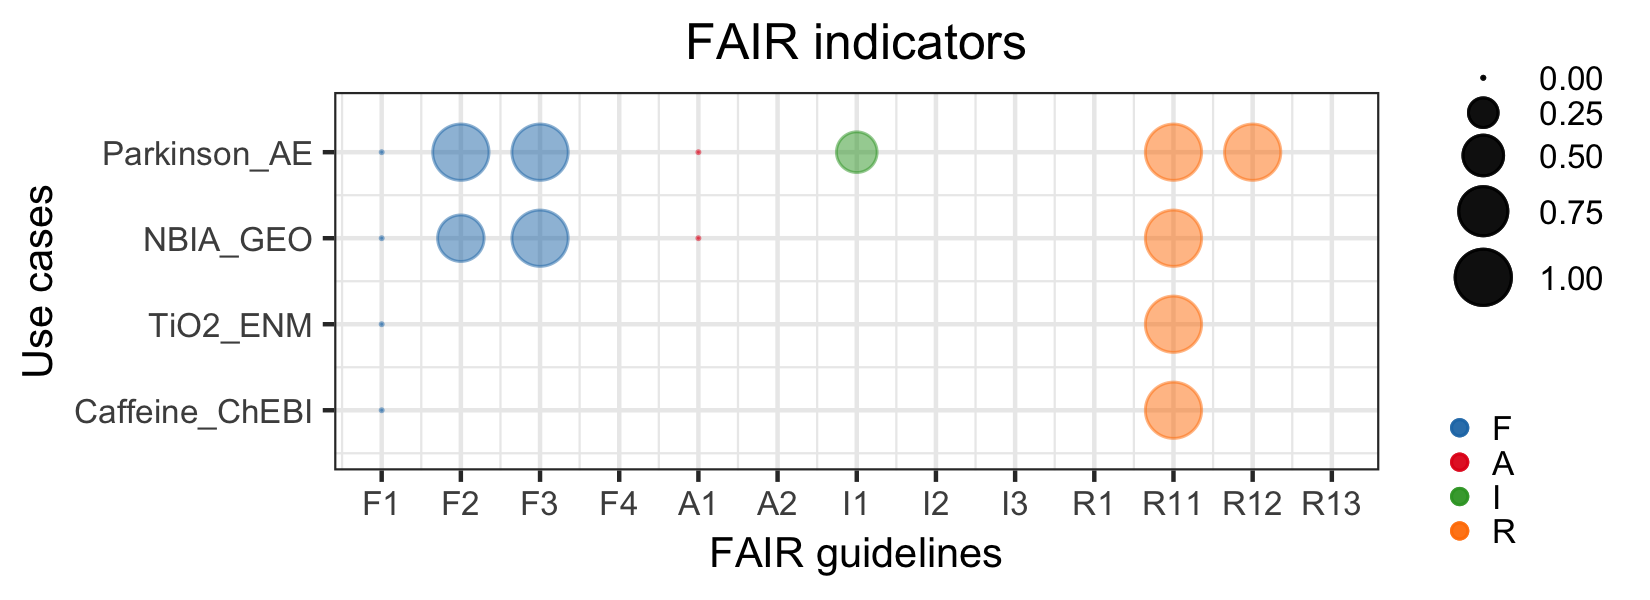

In [58]:
%%R -i df -w 5.5 -h 2 --units in -r 300 #-i df 

library(ggplot2)

title_text_size <- 12
axis_text_size  <- 10
tick_text_size  <- 8

# variables
metric_names  <- c("F1", "F2", "F3", "F4", "A1", "A2", "I1", "I2", "I3", "R1", "R11", "R12", "R13" )
x_values1     <- rep(1, length(metric_names))
x_values2     <- rep(2, length(metric_names))
x_values3     <- rep(3, length(metric_names))
x_values4     <- rep(4, length(metric_names))

y_values     <- seq(1, length(metric_names))
y_values     <- sort(y_values, decreasing = TRUE)
point_color  <- c("F",  "F",  "F",  "F",  "A",  "A",  "I",  "I",  "I",  "R",  "R",   "R",   "R"  )

pl <- ggplot (     data=df, aes(x=x_values1, y=y_values, color=point_color, size=Parkinson_AE))+
        # points (all cases case)
        geom_point(alpha=0.5) +
        geom_point(data=df, aes(x=x_values2, y=y_values, color=point_color, size=NBIA_GEO), alpha=0.5)+
        geom_point(data=df, aes(x=x_values3, y=y_values, color=point_color, size=TiO2_ENM), alpha=0.5)+
        geom_point(data=df, aes(x=x_values4, y=y_values, color=point_color, size=Caffeine_ChEBI), alpha=0.5)+
        scale_size_area() + 
        # background
        theme_bw() +  
        # flip x and y
        coord_flip()  +
        # axis ticks
        scale_x_reverse(limits=c(4.5,0.5), breaks=seq(4,1,-1),  labels=rev(colnames(df))) + 
        scale_y_reverse(limits=c(13, 1),   breaks=seq(13,1,-1), labels=metric_names) + 
        theme(axis.text.x = element_text(size = tick_text_size)) + 
        theme(axis.text.y = element_text(size = tick_text_size)) +
        # axis text
        xlab ("Use cases") +
        ylab ("FAIR guidelines") +
        theme(text = element_text( size = axis_text_size )) + 
        # change colors
        scale_color_manual(values=c("#e31a1c", "#1f78b4", "#33a02c", "#ff7f00") ,
                         labels = c("F", "A", "I", "R"),
                         breaks = c("F", "A", "I", "R")
                         ) +  
        # title
        ggtitle("FAIR indicators") +
        theme(plot.title = element_text(size = title_text_size, hjust = 0.5))  +
        # legend - colors
        theme(legend.text = element_text(size=tick_text_size),
              legend.key.size = unit(0.2, "cm")) + 
        labs(color="") +  # no legend title   
        labs(size="")  +   # no legend title 
        theme (legend.spacing.y = unit(0.05, "cm")) # reduce vertical space between legends
       

# display
pl

---


## Dependencies 

In [47]:
%reload_ext watermark
%watermark -v -m -p bs4,os,pandas,requests,xml.etree.ElementTree,io
print ("")
%watermark -u -n -t -z

CPython 3.7.3
IPython 7.4.0

bs4 4.7.1
os unknown
pandas 0.24.2
requests 2.21.0
xml.etree.ElementTree unknown
io unknown

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.7.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit

last updated: Thu Jul 25 2019 17:15:06 CEST


In [48]:
%%R
sessionInfo()

R version 3.3.3 (2017-03-06)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS  10.13.6

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] ggplot2_3.1.0

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.1       digest_0.6.18    withr_2.1.2      crayon_1.3.4    
 [5] dplyr_0.8.1      assertthat_0.2.1 grid_3.3.3       plyr_1.8.4      
 [9] R6_2.4.0         gtable_0.2.0     magrittr_1.5     scales_1.0.0    
[13] pillar_1.4.0     rlang_0.3.4      lazyeval_0.2.1   labeling_0.3    
[17] glue_1.3.1       purrr_0.3.2      munsell_0.5.0    pkgconfig_2.0.2 
[21] colorspace_1.3-2 tidyselect_0.2.5 tibble_2.1.1    


In [49]:
%watermark -u -n -t -z

last updated: Thu Jul 25 2019 17:15:07 CEST
